<a href="https://colab.research.google.com/github/raneldan/Seam-Carving-Algorithem/blob/main/seam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports 
import numpy as np
import pandas as pd
import cv2 as cv2 
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

In [ ]:
def loadImage(url):
  # load image 
  image = io.imread(url) 

  # convert the image to gray level
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # preper the image for resizing by calculating the seams. Only calculate 25 seams. Can be adjusted
  return [image, calculateBatchSeamV(image, 25), calculateBatchSeamH(image, 25)]

In [ ]:
def calculateEnergy(image):
  # define kernels and gradient
  kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
  kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
  edges_x = cv2.filter2D(image,cv2.CV_8U,kernelx)
  edges_y = cv2.filter2D(image,cv2.CV_8U,kernely)

  # create and return energy matrix
  return (edges_x + edges_y).astype(int)

In [ ]:
# help function to find min horizontally
def findMinH(mat, i , j):
  if (j == 0):
    return min(mat[i-1][j], mat[i-1][j+1])
  if (j == mat.shape[1]-1):
    return  min(mat[i-1][j], mat[i-1][j-1])

  return min(mat[i-1][j], mat[i-1][j-1], mat[i-1][j+1])

In [ ]:
# help function to find min verticly
def findMinV(mat, i , j):
  if (i == 0):
    return min(mat[i][j-1], mat[i+1][j-1])
  if (i == mat.shape[0]-1):
    return  min(mat[i][j-1], mat[i-1][j-1])
    
  return  min(mat[i-1][j-1], mat[i][j-1], mat[i+1][j-1])

In [ ]:
# create and fill the dynamic matrix for vertical dimention
def createDynamicH(image, energy):
  energyH = energy[:,:]
  dynamicH = np.zeros(energyH.shape)
  dynamicH[:0] = energyH[:0]

  for col in range (1 , energyH.shape[1]):
    for row in range (0 , energyH.shape[0]):
      dynamicH[row][col] = int(energyH[row][col]) + int(findMinH(dynamicH,row,col))
  return dynamicH

In [ ]:
# create and fill the dynamic matrix for horizontal dimention
def createDynamicV(image, energy):
  energyV = energy[:,:]
  dynamicV = np.zeros(energyV.shape)
  dynamicV[0:] = energyV[0:]

  for row in range (1 , energyV.shape[0]):
    for col in range (0 , energyV.shape[1]):
      dynamicV[row][col] = int(energyV[row][col]) + int(findMinV(dynamicV,row,col))
  return dynamicV

In [ ]:
def findMinSeamV(energy):
  # finding the min seam verticly in the energy function
  result = []
  result.append(np.argmin(energy[-1:,]))
  for i in range (1, energy.shape[0]):
    curr = energy[-i][result[i-1]]
    if (result[i-1] == 0):
      next = energy[-i][result[i-1]+1]
      result.append(result[i-1] + np.argmin([curr,next]))
    elif (result[i-1] == energy.shape[1]-1):
      prev = energy[-i][result[i-1]-1]
      result.append(result[i-1] + np.argmin([prev,curr]) - 1)
    else:
      next = energy[-i][result[i-1]+1]
      prev = energy[-i][result[i-1]-1]
      result.append(result[i-1] + np.argmin([prev,curr,next]) - 1)
  return result[::-1]



In [ ]:
# finding the min seam horizontally in the energy function
def findMinSeamH(energy):
  result = []
  result.append(np.argmin(energy[:,-1]))
  for i in range (1, energy.shape[1]):
    curr = energy[result[i-1]][-i]
    if (result[i-1] == 0):
      next = energy[result[i-1]+1][-i]
      result.append(result[i-1] + np.argmin([curr,next]))
    elif (result[i-1] == energy.shape[0]-1):
      prev = energy[result[i-1]-1][-i]
      result.append(result[i-1] + np.argmin([prev,curr]) - 1)
    else:
      next = energy[result[i-1]+1][-i]
      prev = energy[result[i-1]-1][-i]
      result.append(result[i-1] + np.argmin([prev,curr,next]) - 1)
  return result[::-1]

In [ ]:
# adding a single seam to the image (vericly)
def addSeamV(image, seam):
  length = len(seam)
  seamValues = np.empty(length)
  seamValues[0] = (int(image[0, seam[0]]) +  int(image[1, seam[0]])) / 2
  for i in range (1, length-1):
    seamValues[i] = (int(image [i-1, seam[i]]) + int(image[i, seam[i]]) + int(image[i+1, seam[i]])) / 3
  seamValues[length-1] = (int(image[length-2, seam[length-1]]) + int(image[length-1, seam[length-1]])) / 2
  ravel_index = np.ravel_multi_index((np.arange(length), np.asarray(seam)), image.shape)
  image = np.insert(image, ravel_index, seamValues).reshape(length,image.shape[1]+1)
  return image

In [ ]:
# Adding a single seam to the image (horizontally)
def addSeamH(image, seam):
  image = np.matrix.transpose(image)
  image = addSeamV(image,seam)
  image = np.matrix.transpose(image)
  return image

In [ ]:
# Remove a single seam (verticlly)
def removeSeamV(image, seam):
  ravel_index = np.ravel_multi_index((np.arange(len(seam)), np.asarray(seam)), image.shape)
  image = np.delete(image, ravel_index).reshape(len(seam),image.shape[1]-1)
  return image



In [ ]:
# debug function - marking the seams on the image (verticlly)
def showSeamsV(image,seamArr):
  copyImage = image.copy()
  for i in range (0,image.shape[0]):
    for j in range (0,len(seamArr)):
      copyImage[i,seamArr[j][i]] = 0
  return copyImage

In [ ]:
# debug function - marking the seams on the image (horizontally)
def showSeamsH(image,seamArr):
  copyImage = image.copy()
  for i in range (0,len(seamArr)):
    for j in range (0,image.shape[1]):
      copyImage[seamArr[i][j],j] = 0
  return copyImage

In [ ]:
# Remove a single seam (horizontally)
def removeSeamH(image, seam):
  image = np.matrix.transpose(image)
  image = removeSeamV(image,seam)
  image = np.matrix.transpose(image)
  return image

In [ ]:
# Removing 'size' seams from the image (verticlly) 
def removeMultiSeamV(image, size):
  for i in range (0, size):
    dynamicV = createDynamicV(image,calculateEnergy(image))
    image = removeSeamV(image,findMinSeamV(dynamicV))
  return image


In [ ]:
# Removing 'size' seams from the image (horizontally) 
def removeMultiSeamH(image, size):
  for i in range (0, size):
    dynamicH = createDynamicH(image,calculateEnergy(image))
    image = removeSeamH(image,findMinSeamH(dynamicH))
  return image

In [ ]:
# Prepering 'size' seams to be removed whenever needed (verticlly)
def calculateBatchSeamV(image, size):
  copyImage = image
  seamArr = []
  for i in range (0, size):
    dynamicV = createDynamicV(copyImage,calculateEnergy(copyImage))
    seamArr.append(findMinSeamV(dynamicV))
    copyImage = removeSeamV(copyImage,seamArr[i])
  return seamArr

In [ ]:
# Prepering 'size' seams to be removed whenever needed (horizontally)
def calculateBatchSeamH(image, size):
  copyImage = image
  seamArr = []
  for i in range (0, size):
    dynamicH = createDynamicH(copyImage,calculateEnergy(copyImage))
    seamArr.append(findMinSeamH(dynamicH))
    copyImage = removeSeamH(copyImage,seamArr[i])
  return seamArr

In [ ]:
# Removeing batch of seams from the picture (verticlly)
def removeBatchSeamV(image, seamArr, size):
  for seam in range (0, min(size,len(seamArr))):
    image = removeSeamV(image, seamArr[seam])
  return image

In [ ]:
# Removeing batch of seams from the picture (horizontally)
def removeBatchSeamH(image, seamArr, size):
  for seam in range (0, min(size,len(seamArr))):
    image = removeSeamH(image, seamArr[seam])
  return image

In [ ]:
# Adding batch of seams from the picture (verticlly)
def addBatchSeamV(image, seamArr, size):
  for seam in range (0, min(size,len(seamArr))):
    image = addSeamV(image, seamArr[seam])
  return image

In [ ]:
# Adding batch of seams from the picture (horizontally)
def addBatchSeamH(image, seamArr, size):
  for seam in range (0, min(size,len(seamArr))):
    image = addSeamH(image, seamArr[seam])
  return image

In [ ]:
# Get an image and rectangle represented by 4 points and removeing it from the image
def removeObject(image, points):
  size = checkDim(points)[1]
  if (checkDim(points)[0] == 'V'):
    image = removeObjectV(image, [points[0],points[1]])
    seamArr = calculateBatchSeamV(image, size)
    image = addBatchSeamV(image, seamArr, size)
    return image
  else:
    image = removeObjectH(image, [points[2],points[3]])
    seamArr = calculateBatchSeamH(image, size)
    image = addBatchSeamH(image, seamArr, size)
    return image

In [ ]:
# Forcing the removal of the object from the image by setting the enrgy of all the seams to -1 (the min is 0) - Verticlly
def removeObjectH(image, points):
  for i in range (points[0], points[1]):
    energy = calculateEnergy(image)
    dynamic = createDynamicH(image, energy)
    energy[i][image.shape[1]-1] = int(-1)
    seam = findMinSeamH(energy)
    image = removeSeamH(image,seam)
  return image

In [ ]:
# Forcing the removal of the object from the image by setting the enrgy of all the seams to -1 (the min is 0) - Horizontally
def removeObjectV(image, points):
    for i in range (points[0], points[1]):
      energy = calculateEnergy(image)
      dynamic = createDynamicV(image, energy)
      energy[image.shape[0]-1][i] = int(-1)
      seam = findMinSeamV(energy)
      image = removeSeamV(image,seam)
    return image

In [ ]:
# Check and return the smallest dim, this dim will be removed from the image
def checkDim(points):
  if ((points[1] - points[0]) <= (points[3] - points[2])):
    return ['V', (points[1] - points[0])]
  return ['H', (points[3] - points[2])]

In [ ]:
# Needed to be run once (per image) - loading the image and "offline" calculating the seams 
[image, seamArrV, seamArrH] = loadImage("https://iiif.lib.ncsu.edu/iiif/0052574/full/800,/0/default.jpg")

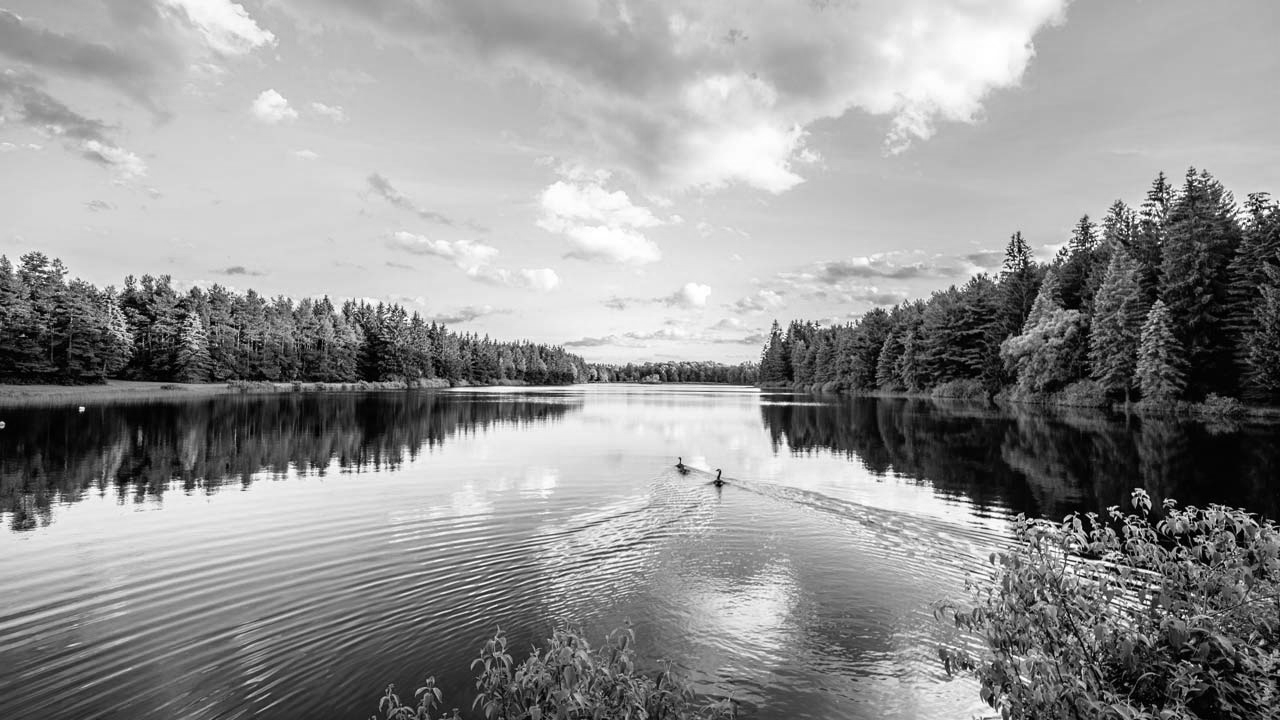

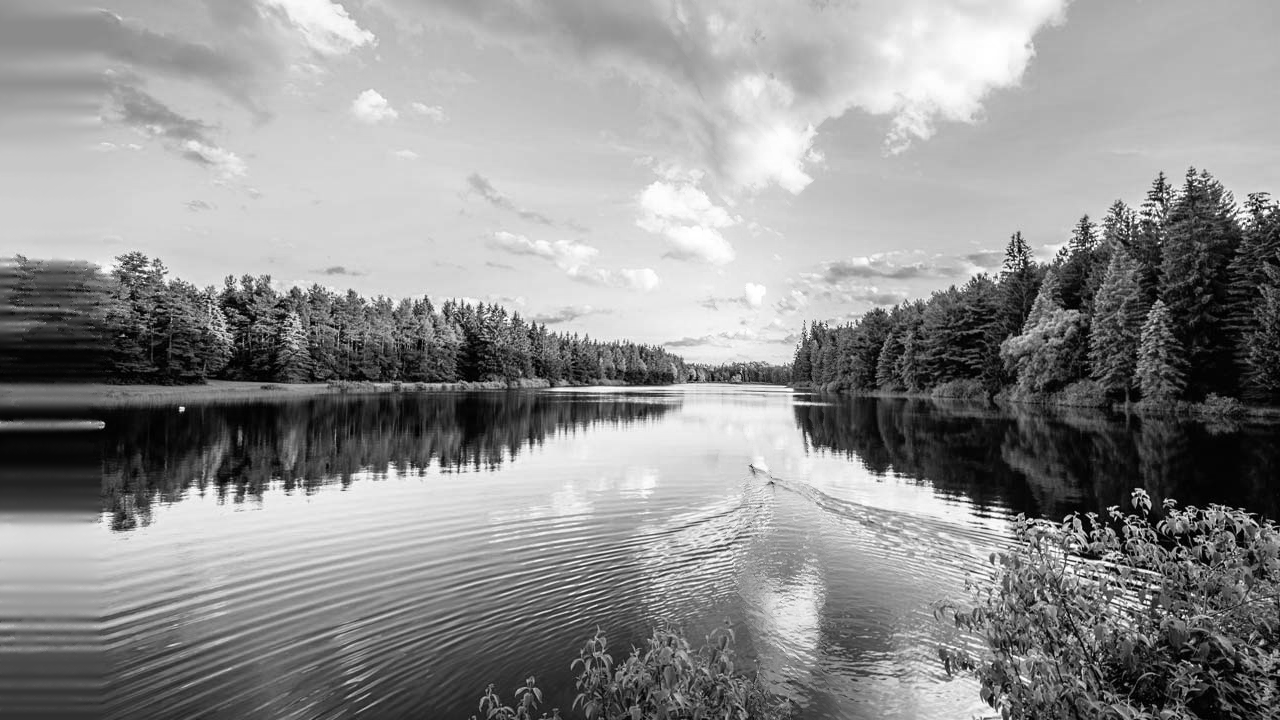

(720, 1280)
(720, 1280)


In [ ]:
### MAIN PROGRAM ###

# Un-comment relevant sections to see thier effect

# show the initial image
#cv2_imshow(image)
# visually see what seams are about to be removed
#image2 = showSeamsH(image, seamArrH)
#cv2_imshow(image2)
#image3 = showSeamsV(image, seamArrV)
#cv2_imshow(image3)
# Resize the picture with pre-computed seams 
# Remove vertical seams
#image4 = removeBatchSeamV(image, seamArrV, 25)
#cv2_imshow(image4)
# Remove horizontal seams
#image5 = removeBatchSeamH(image, seamArrH, 10)
#cv2_imshow(image5)
#Amlpify the picture vertical seams
#image6 = addBatchSeamV(image, seamArrV, 15)
#cv2_imshow(image6)
#Amplify the picture horizontal seams
#image7 = addBatchSeamH(image, seamArrH, 25)
#cv2_imshow(image7)
# Remove object from the picture by given coordientates
#image8 = removeObject(image,[650,750,110,790])
#cv2_imshow(image8)



